# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

## Get data

Since we'll be replicating the paper (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 21.92 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [2]:
# Check what files are the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [4]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one iwth the data is to...

> Visualize,Visualize,Visualize

So with that in mind , lets' write a function to read in all the lines of a target txt file.

In [5]:
# Create function to read the lines f a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of string with one string per line from the target filename.
  """
  with open(filename,'r') as f:
    return f.readlines()

In [6]:
# Let's read in the trining lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training line
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number' : 0,
    'target': BACKGROUND,
    'text' : 'Emotional eating is associated with overeating and the development of obesity .\n'
    'total_lines' : 11},
    ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [8]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extractiong things like the target label, thet text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples= [] # create an empty list of abstract

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line isa new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data={} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get the target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the taet abstract? (we are starting from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions are.t fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples= preprocess_text_with_line_numbers(data_dir+"dev.txt") # dev is another name for validation
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 919 ms, sys: 192 ms, total: 1.11 s
Wall time: 2.31 s


In [10]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

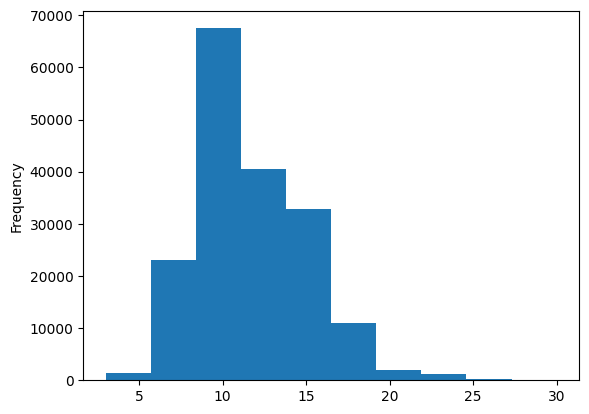

In [13]:
# Let's chechk length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require labels)

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modlling eperiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as alwasys, we're going to start with a baseline (TF-IDF Multinominal Navie Bayes classifier)

## Model 0: Getting a baseline

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
len(val_sentences),len(val_labels_encoded)

(30212, 30212)

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(val_sentences,
              val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script.

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-29 13:13:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-12-29 13:13:02 (18.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split())for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

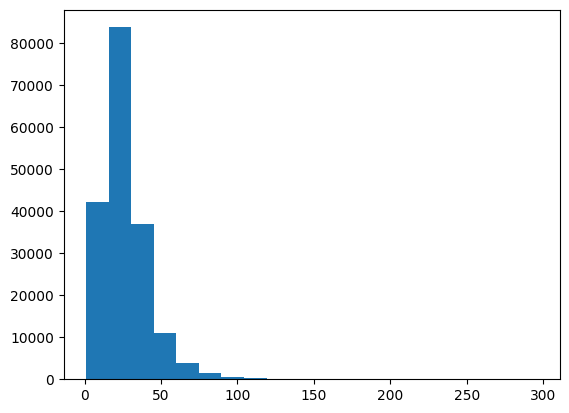

In [28]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20);

In [29]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [30]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [31]:
# How many words in our vocab?
max_tokens = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [33]:
# Adpat text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of Text:{len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
to observe the effect of postoperative analgesia with dexmedetomidine on the survival rate of amputated finger replantation .

Length of Text:125

Vectorized text: [[    6  1756     2    70     4   163   673     7  1509    18     2   201
     78     4 32713  3915 19729     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                              output_dim=128,# Note: different embedding sizes result in drasrically different numbers of parameters to train
                               mask_zero=True,# Use masking to handle variable sequence length (save space)
                               name="token_embedding")

In [38]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 to observe the effect of postoperative analgesia with dexmedetomidine on the survival rate of amputated finger replantation .

Sentence after vectorization (before embedding):
 [[    6  1756     2    70     4   163   673     7  1509    18     2   201
     78     4 32713  3915 19729     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.02959063  0.03843303 -0.0332964  ...  0.01825769  0.04978747
   -0.02302809]
  [-0.03606304  0.03734947 -0.04404167 ...  0.01415647  0.00260372
    0.01876586]
  [ 0.04785278  0.00690837  0.00765125 ... -0.01124463  0.03637205
    0.04675326]
  ...
  [ 0.04660198  0.03542849 -0.02055492 ...  0.04978145 -0.03314922
   -0.04182975]
  [ 0.04660198  0.03542849 -0.02055492 ...  0.04978145 -0.03314922
   -0.04182975]


## Creating datasets (making sure our data loads as fast as possible)

In [39]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [41]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vectors
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [42]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [43]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 114s 199ms/step - loss: 0.9136 - accuracy: 0.6387 - val_loss: 0.6861 - val_accuracy: 0.7357
Epoch 2/3
562/562 [==============================] - 109s 194ms/step - loss: 0.6577 - accuracy: 0.7572 - val_loss: 0.6323 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 95s 169ms/step - loss: 0.6194 - accuracy: 0.7745 - val_loss: 0.5993 - val_accuracy: 0.7849


In [44]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 8s 9ms/step - loss: 0.6013 - accuracy: 0.7848


[0.6013278961181641, 0.7847874760627747]

In [45]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 11s 11ms/step


(array([[4.44696069e-01, 1.85601145e-01, 7.56959319e-02, 2.67944217e-01,
         2.60626804e-02],
        [3.99535954e-01, 3.25354725e-01, 1.15176765e-02, 2.55150914e-01,
         8.44073016e-03],
        [1.11854985e-01, 8.25623143e-03, 1.34695426e-03, 8.78515542e-01,
         2.62326175e-05],
        ...,
        [5.99794976e-06, 8.45632807e-04, 9.03782900e-04, 2.84300177e-06,
         9.98241782e-01],
        [5.00364564e-02, 4.42399323e-01, 1.05560280e-01, 6.77444488e-02,
         3.34259570e-01],
        [2.05807045e-01, 6.20545983e-01, 4.20649648e-02, 5.26316874e-02,
         7.89502487e-02]], dtype=float32),
 (30212, 5))

In [46]:
# Convert pred probs to classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [47]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 78.47875016549716,
 'precision': 0.7818826871795578,
 'recall': 0.7847875016549716,
 'f1': 0.7824023129002254}

## Model 2: Feature extraction with pretrained token embedding

In [48]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name="universal_sentence_encoder")

In [49]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence: 
 combined treatment enhanced the rate of recovery vs treatment with adm alone ( @ % vs @ % ; t@ = @ ; p = @ ; hazard ratio -lsb- hr -rsb- , @ ; @ % ci , @-@ @ ; number needed to treat -lsb- nnt -rsb- , @ ; @ % ci , @-@ ) .
Sentence after embedding:
 [-0.02282235 -0.08103731 -0.04019659 -0.01809108  0.06085833 -0.07247102
 -0.02240757 -0.00127338  0.0684655   0.04641881  0.08120194 -0.04193921
 -0.03049914  0.03411508  0.02686599 -0.00442647 -0.07570139 -0.03642549
 -0.02044892  0.04251366  0.04954997 -0.03962503 -0.00807528 -0.01126763
  0.05460579  0.05315501  0.00529129 -0.05495696 -0.0596924  -0.03485652]

Length of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embedding TensorFlow Hub

In [50]:
# Define feature extraction model using TF hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x) # Create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs = outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [52]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 17ms/step - loss: 0.9173 - accuracy: 0.6507 - val_loss: 0.7948 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7675 - accuracy: 0.7028 - val_loss: 0.7523 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 16s 28ms/step - loss: 0.7500 - accuracy: 0.7120 - val_loss: 0.7366 - val_accuracy: 0.7151


In [53]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.7398 - accuracy: 0.7145


[0.7398219108581543, 0.7145174145698547]

In [54]:
# Make prediction with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 19s 19ms/step


array([[4.0756467e-01, 3.9447841e-01, 2.2763205e-03, 1.8907103e-01,
        6.6095875e-03],
       [3.6257821e-01, 4.8398188e-01, 2.9336023e-03, 1.4855804e-01,
        1.9480925e-03],
       [2.5994483e-01, 1.2927616e-01, 1.6468918e-02, 5.5791157e-01,
        3.6398567e-02],
       ...,
       [1.7880019e-03, 5.9412080e-03, 5.6165937e-02, 7.5897953e-04,
        9.3534583e-01],
       [4.6182061e-03, 5.4640651e-02, 1.8574715e-01, 1.4889770e-03,
        7.5350505e-01],
       [1.6944110e-01, 2.4173124e-01, 5.2647096e-01, 7.2273524e-03,
        5.5129420e-02]], dtype=float32)

In [55]:
# Convert the prediction probabilities found with feature extraction model to label
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [56]:
# Calculate results from TF hub pretrained embeddings results in val set
model_2_results = calculate_results(val_labels_encoded,
                                   model_2_preds)
model_2_results

{'accuracy': 71.45174103005428,
 'precision': 0.7147245448149979,
 'recall': 0.7145174103005428,
 'f1': 0.7115186997401731}

In [57]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings

### Creating a character level tokenizer

In [58]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-chachter-level sequence into character
split_chars(random_train_sentence)

'c o m b i n e d   t r e a t m e n t   e n h a n c e d   t h e   r a t e   o f   r e c o v e r y   v s   t r e a t m e n t   w i t h   a d m   a l o n e   (   @   %   v s   @   %   ;   t @   =   @   ;   p   =   @   ;   h a z a r d   r a t i o   - l s b -   h r   - r s b -   ,   @   ;   @   %   c i   ,   @ - @   @   ;   n u m b e r   n e e d e d   t o   t r e a t   - l s b -   n n t   - r s b -   ,   @   ;   @   %   c i   ,   @ - @   )   .'

In [59]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [60]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

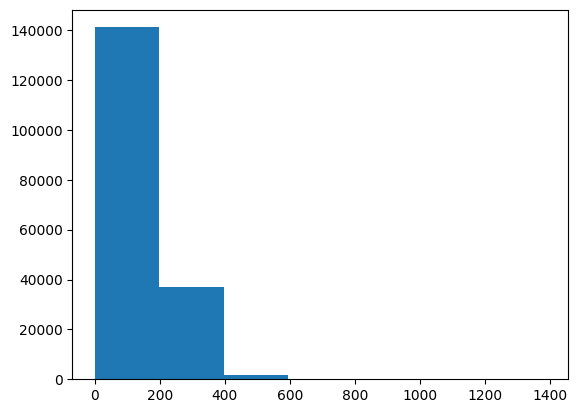

In [61]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [62]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [63]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [64]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = Out of Vocab,["UNK"])
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize='lower_and_strip_punctuation',
                                    name="char_vectorizer")

In [65]:
# Adapt character vectorizer to training chacater
char_vectorizer.adapt(train_chars)

In [66]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [67]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t o p i c a l   a p p l i c a t i o n   o f   m u p i r o c i n   o i n t m e n t   a c h i e v e s   b e t t e r   r e s u l t s   f o r   t h e   p r e v e n t i o n   o f   s s i   t h a n   i o n i c   s i l v e r - c o n t a i n i n g   d r e s s i n g   o r   s t a n d a r d   d r e s s i n g   i n   p a t i e n t s   u n d e r g o i n g   e l e c t i v e   o p e n   c o l o r e c t a l   s u r g e r y   .
Length of random_train_chars: 181

Vectorized chars:
 [[ 3  7 14  4 11  5 12  5 14 14 12  4 11  5  3  4  7  6  7 17 15 16 14  4
   8  7 11  4  6  7  4  6  3 15  2  6  3  5 11 13  4  2 21  2  9 22  2  3
   3  2  8  8  2  9 16 12  3  9 17  7  8  3 13  2 14  8  2 21  2  6  3  4
   7  6  7 17  9  9  4  3 13  5  6  4  7  6  4 11  9  4 12 21  2  8 11  7
   6  3  5  4  6  4  6 18 10  8  2  9  9  4  6 18  7  8  9  3  5  6 10  5
   8 10 10  8  2  9  9  4  6 18  4  6 14  5  3  4  2  6  3  9 16  6 10  2
   8 18  7  4  6 18  2 12  2 11  3  4 21  2  7 14  2  6 11  7 12  7  

## Creating a character level embedding

In [68]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim = 25,
                              mask_zero=True,
                              name="char_embed")

In [69]:
# Test out character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example= char_embed(char_vectorizer([random_train_chars]))
print(f"Embeddedd chars: (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t o p i c a l   a p p l i c a t i o n   o f   m u p i r o c i n   o i n t m e n t   a c h i e v e s   b e t t e r   r e s u l t s   f o r   t h e   p r e v e n t i o n   o f   s s i   t h a n   i o n i c   s i l v e r - c o n t a i n i n g   d r e s s i n g   o r   s t a n d a r d   d r e s s i n g   i n   p a t i e n t s   u n d e r g o i n g   e l e c t i v e   o p e n   c o l o r e c t a l   s u r g e r y   .

Embeddedd chars: (after vectorization and embedding):
 [[[-0.04571482  0.02896566  0.0367239  ...  0.02928163 -0.02825261
   -0.01807662]
  [ 0.02731604  0.03132153  0.03890627 ... -0.00392646  0.04890205
   -0.02019474]
  [ 0.01537199  0.04835982 -0.04539507 ...  0.0137114  -0.03473901
    0.00155898]
  ...
  [-0.02065797 -0.04306284 -0.01238345 ...  0.04045689 -0.00657723
    0.03462872]
  [-0.02065797 -0.04306284 -0.01238345 ...  0.04045689 -0.00657723
    0.03462872]
  [-0.02065797 -0.04306284 -0.01238345 ...  0.04045689 -0.00657723
    0.03462872]]]

Char

### Building a Conv1D model to fit on character embeddings

In [70]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,),dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size =5,padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_3= tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [71]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [72]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data= val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 18s 31ms/step - loss: 1.2593 - accuracy: 0.4947 - val_loss: 1.0253 - val_accuracy: 0.5931
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.9853 - accuracy: 0.6099 - val_loss: 0.9348 - val_accuracy: 0.6293
Epoch 3/3
562/562 [==============================] - 19s 33ms/step - loss: 0.9143 - accuracy: 0.6376 - val_loss: 0.8728 - val_accuracy: 0.6513


In [73]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[0.09593711, 0.4368082 , 0.14872035, 0.24873364, 0.06980078],
       [0.18544194, 0.44471315, 0.02409532, 0.33020037, 0.01554924],
       [0.12241683, 0.19791561, 0.07743978, 0.5907655 , 0.01146234],
       ...,
       [0.00831608, 0.01938613, 0.07246298, 0.00352053, 0.89631426],
       [0.10542736, 0.21771254, 0.21210174, 0.10896254, 0.35579583],
       [0.32416478, 0.5161754 , 0.06383359, 0.09075396, 0.00507222]],
      dtype=float32)

In [74]:
# Convert prediction probabilites to class labels
model_3_preds= tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [75]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(val_labels_encoded,model_3_preds)
model_3_results

{'accuracy': 65.7818085528929,
 'precision': 0.6554649211712866,
 'recall': 0.657818085528929,
 'f1': 0.6505873363127335}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character_level model (similar to `model_3` with slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of paper
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilites as output

In [76]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[],dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,
                             token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype =tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_concat")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs= output_layer,
                         name="model_4_token_and_char_embeddings")

In [77]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['input_4[0][0]']             
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

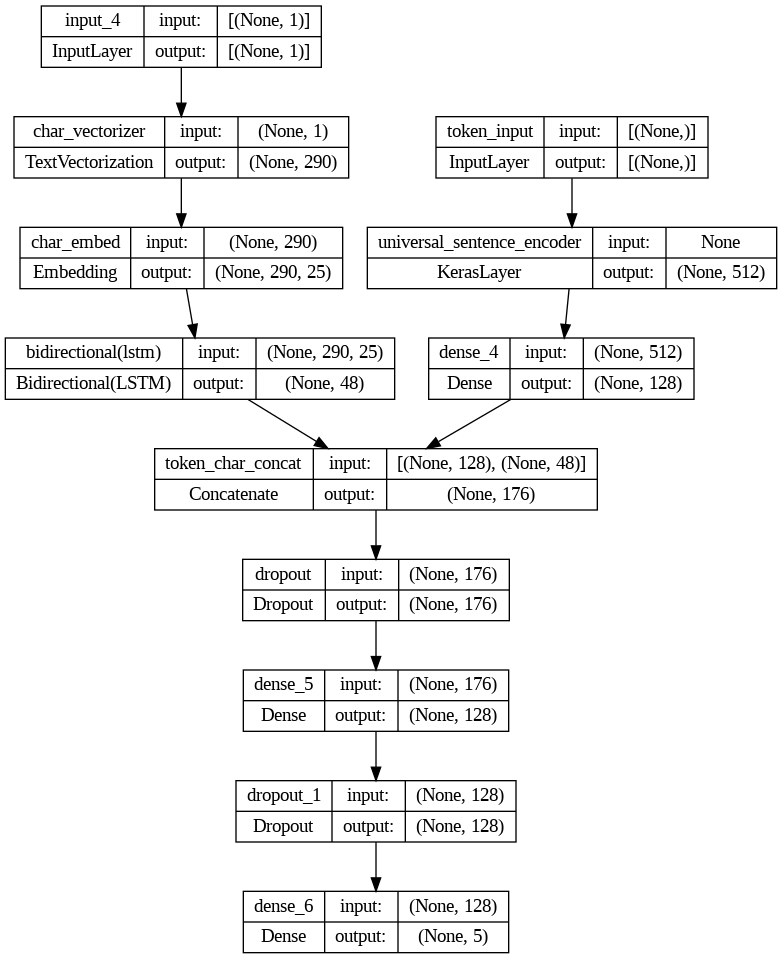

In [78]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [79]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data  into a tf.data.Dataset

In [80]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [82]:
# Check out out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [83]:
# Fit the model on token and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 210s 351ms/step - loss: 0.9907 - accuracy: 0.6059 - val_loss: 0.7806 - val_accuracy: 0.7058
Epoch 2/3
562/562 [==============================] - 189s 336ms/step - loss: 0.8012 - accuracy: 0.6905 - val_loss: 0.7158 - val_accuracy: 0.7251
Epoch 3/3
562/562 [==============================] - 214s 381ms/step - loss: 0.7742 - accuracy: 0.7051 - val_loss: 0.6939 - val_accuracy: 0.7360


In [84]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 66s 69ms/step - loss: 0.6955 - accuracy: 0.7337


[0.6955116391181946, 0.7336819767951965]

In [85]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 62s 62ms/step


array([[4.4828409e-01, 3.5304272e-01, 4.1565956e-03, 1.8372536e-01,
        1.0791202e-02],
       [3.7620124e-01, 4.4260237e-01, 2.1421474e-03, 1.7738242e-01,
        1.6718610e-03],
       [2.9967371e-01, 1.0765724e-01, 3.2357056e-02, 5.3837246e-01,
        2.1939503e-02],
       ...,
       [7.9163612e-04, 8.0666719e-03, 5.3330008e-02, 2.9813530e-04,
        9.3751359e-01],
       [7.5294264e-03, 4.6051852e-02, 2.6852879e-01, 3.2106503e-03,
        6.7467928e-01],
       [2.0039520e-01, 4.5781347e-01, 2.6081285e-01, 2.6295418e-02,
        5.4683004e-02]], dtype=float32)

In [86]:
# Format pred probs into pred labels
model_4_preds= tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [87]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(val_labels_encoded,model_4_preds)
model_4_results

{'accuracy': 73.36819806699324,
 'precision': 0.7357189303075246,
 'recall': 0.7336819806699325,
 'f1': 0.7309035469486893}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [88]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


**🔑Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers total lines are available.

### Create positional embeddings

In [89]:
# How many different line numbers are there
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

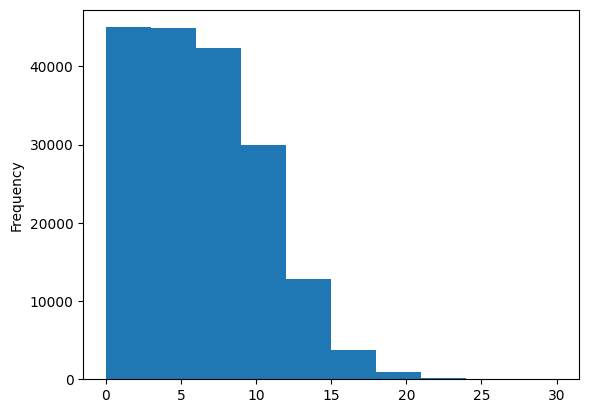

In [90]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist();

In [91]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [92]:
# How many different numbers of lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

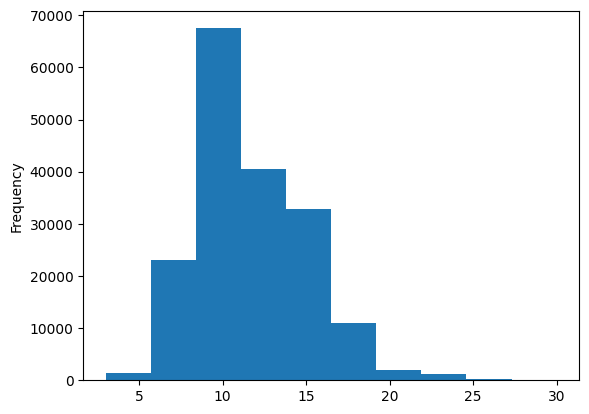

In [93]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [94]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [95]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4, 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribred embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a `tf.keras.Model`

In [105]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype='string', name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24,))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

# 3. Line Number model
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,
                                 outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,
                                   y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                total_lines_model.output,
                                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.inputs,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [106]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

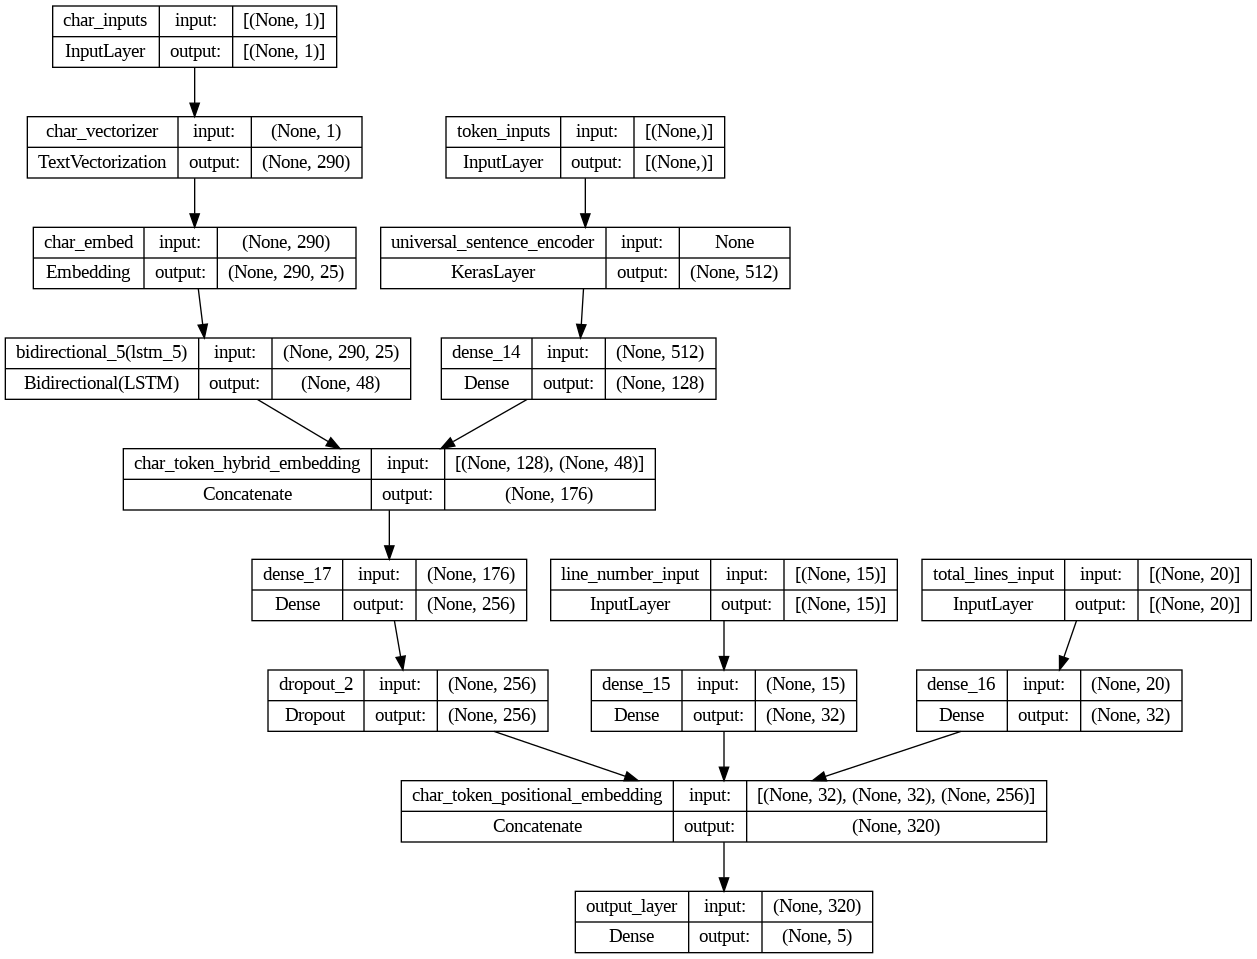

In [109]:
# Plot model_5 to explore it visully...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [110]:
# Compile token, char, and postional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embeddings datasets using tf.data

In [112]:
# Create training and validation datasets (with all four kings of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip(train_char_token_pos_data, train_char_token_pos_labels)
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip(val_char_token_pos_data, val_char_token_pos_labels)
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [113]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_data

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [114]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 275s 461ms/step - loss: 1.0949 - accuracy: 0.7290 - val_loss: 0.9807 - val_accuracy: 0.8095
Epoch 2/3
562/562 [==============================] - 168s 299ms/step - loss: 0.9668 - accuracy: 0.8164 - val_loss: 0.9480 - val_accuracy: 0.8241
Epoch 3/3
562/562 [==============================] - 201s 358ms/step - loss: 0.9490 - accuracy: 0.8241 - val_loss: 0.9384 - val_accuracy: 0.8291


In [115]:
# Make predictions with char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 100s 99ms/step


array([[0.4972827 , 0.11963848, 0.01062154, 0.3572168 , 0.01524041],
       [0.52228624, 0.09812471, 0.04260524, 0.3237353 , 0.01324854],
       [0.30887085, 0.12030106, 0.10188802, 0.40629655, 0.06264362],
       ...,
       [0.03061157, 0.10265469, 0.0407834 , 0.02808724, 0.79786307],
       [0.03149464, 0.27256975, 0.0719566 , 0.0255572 , 0.5984219 ],
       [0.22426714, 0.60049623, 0.07147399, 0.04406834, 0.0596943 ]],
      dtype=float32)

In [117]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [118]:
# Calculate results of char token pos model
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

{'accuracy': 83.34105653382761,
 'precision': 0.8325117526763409,
 'recall': 0.8334105653382762,
 'f1': 0.8324663378164288}

## Compare model results

In [121]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                 "model_1_custom_token_embedding": model_1_results,
                                 "model_2_pretrained_token_embedding": model_2_results,
                                 "model_3_custom_char_embedding":model_3_results,
                                 "model_4_hybrid_char_token_embedding":model_4_results,
                                 "model_5_pos_char_token_embedding":model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.478750,0.781883,0.784788,0.782402
model_2_pretrained_token_embedding,71.451741,0.714725,0.714517,0.711519
model_3_custom_char_embedding,65.781809,0.655465,0.657818,0.650587
model_4_hybrid_char_token_embedding,73.368198,0.735719,0.733682,0.730904
model_5_pos_char_token_embedding,83.341057,0.832512,0.833411,0.832466


In [122]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results['accuracy']/100

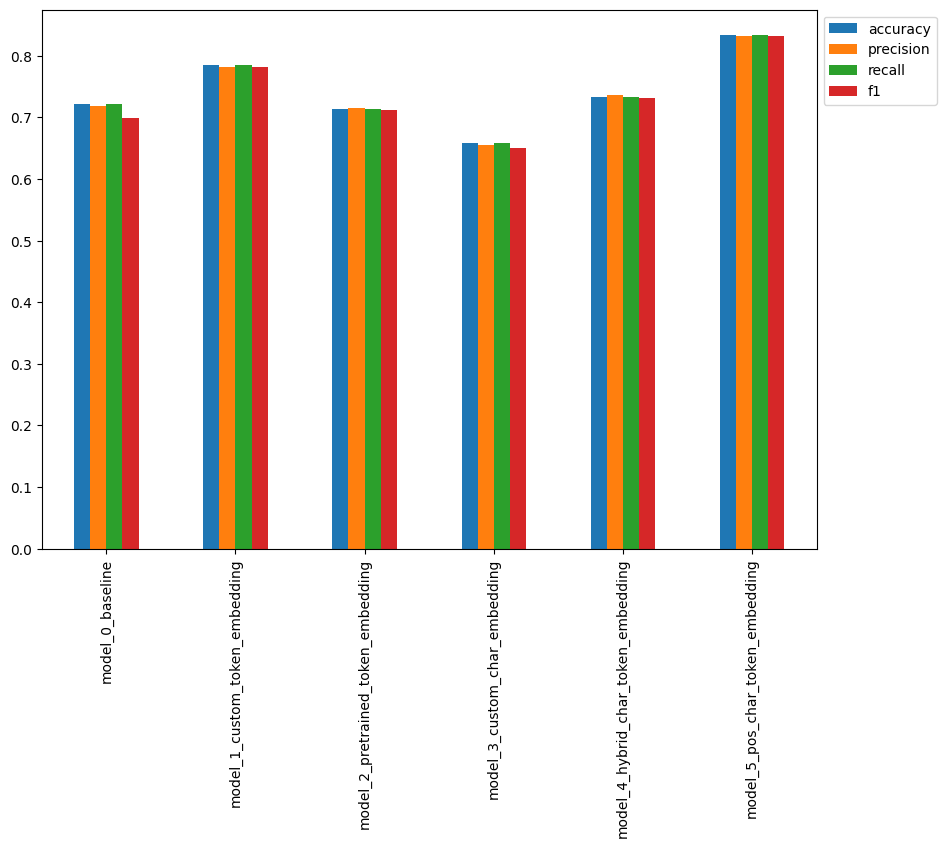

In [124]:
# Plot and compare all model results
all_model_results.plot(kind='bar',figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

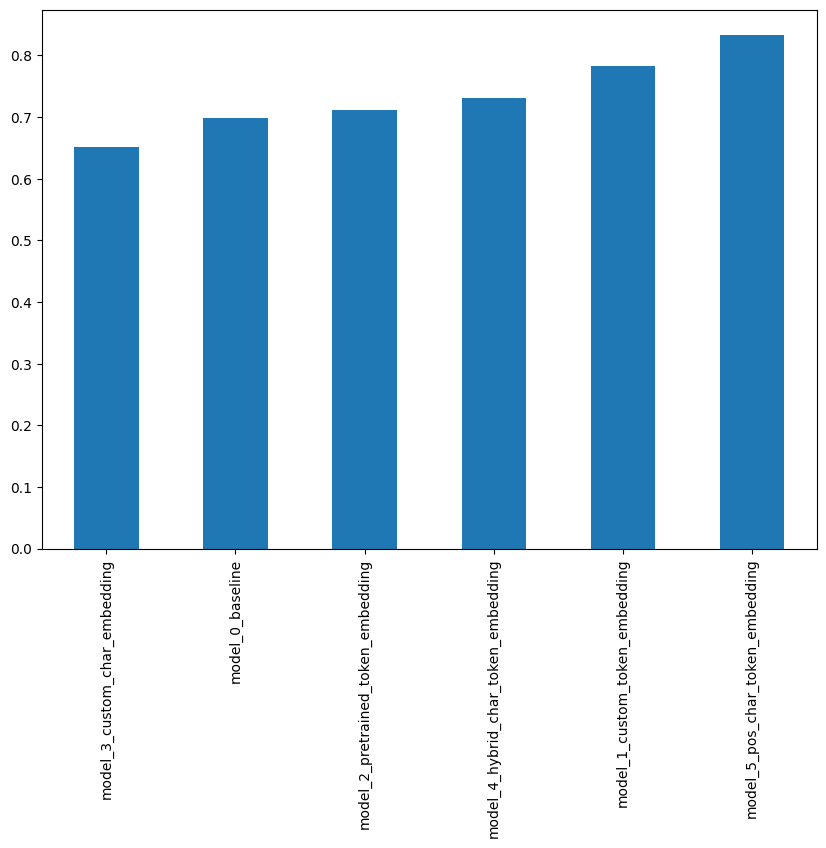

In [125]:
# Sort models results bt f1-score
all_model_results.sort_values("f1",ascending=True)['f1'].plot(kind='bar',figsize=(10,7))

## Save and load model

In [126]:
# Save the best performing model to SavedModel format (defaultt)
model_5.save("skimlit_tribrid_model")

In [127]:
# Load in best performing model
loaded_model = tf.keras.models.load_model('skimlit_tribrid_model')

In [128]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs= loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 95s 94ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [132]:
# Calculate of out loaded model
loaded_model_results = calculate_results(val_labels_encoded,
                                        loaded_preds)
loaded_model_results

{'accuracy': 83.34105653382761,
 'precision': 0.8325117526763409,
 'recall': 0.8334105653382762,
 'f1': 0.8324663378164288}

In [133]:
assert model_5_results == loaded_model_results

In [134]:
# Check the loaded model_summary
loaded_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 